# WELCOME TO THE ORCA NOTEBOOK - MS2 Auxilary

Pipeline for the **O**bjective **R**elational **C**omparative **A**nalyses of mass spectral data, along with other data sources. All you need is a directory of mzML files to get started!

To run cells of code, select cell and then press **Shift + Enter**. The first cell loads-in python modules necessary for the rest of the code to function

In some of the cells below, the user will need to input information, such as setting paths, setting parameters, etc. In these cases, the user will see a cell with variables to be set at the top, followed by a line of '###', below which the rest of the code can be seen. Please set all applicable variables above the '###' line. Tinkering with the code below the '###' line is highly encouraged, as that is precisely why we chose to make the code available as a Jupyter Notebook, however it could result in a 'breaking' of ORCA. If that appears to be the case, simply clone again from GitHub to get back to working code.


This notebook was created several years after ORCA, in order to dig deeper into MS2 fragmentation patterns. Initial analyses using GNPS Classic Molecular Networking (https://gnps.ucsd.edu/ProteoSAFe/static/gnps-splash.jsp) revealed a cluster of MS2 nodes that were networked together, suggesting that they were analogs. In an effort to understand how these nodes might be related, we put together the below code.

In [1]:
import pandas as pd
import numpy as np
from pyteomics import mzml, auxiliary
import glob
import matplotlib 
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, set_link_color_palette, fcluster
from collections import Counter

%matplotlib inline

**path_sample_directory**: Path to the directory that contains sample files to be loaded-in. Note: these files must be in mzML format, and NOT mzXML.

In [3]:
path_sample_directory = './CL001_ms'

################################################################################################################

fns = glob.glob(path_sample_directory + '/*ML')
fns.sort()
fns

['./CL001_ms/2015081301_2232cr-1.mzML',
 './CL001_ms/2015081301_2232cr-10.mzML',
 './CL001_ms/20150821_2232C-1.mzML',
 './CL001_ms/20150821_2232D-1.mzML',
 './CL001_ms/20150821_2232E-1.mzML',
 './CL001_ms/20150821_2232F-1.mzML',
 './CL001_ms/20150821_2232G-1.mzML',
 './CL001_ms/20150821_2232H-1.mzML',
 './CL001_ms/20160603_2246_4mgml.mzML',
 './CL001_ms/20161104_2_2246A.mzML',
 './CL001_ms/20161104_3_2246B.mzML',
 './CL001_ms/20161104_4_2246C.mzML',
 './CL001_ms/20161104_5_2246D.mzML',
 './CL001_ms/20161104_6_2246E.mzML',
 './CL001_ms/20161104_7_2246F.mzML',
 './CL001_ms/20161104_8_2246G.mzML',
 './CL001_ms/20161104_9_2246H.mzML',
 './CL001_ms/20161109_02_2232A2.mzML',
 './CL001_ms/20161109_03_2232B2.mzML',
 './CL001_ms/20161109_03_2246A.mzML',
 './CL001_ms/20161109_04_2232C2.mzML',
 './CL001_ms/20161109_05_2232D2.mzML',
 './CL001_ms/20161109_06_2232E2.mzML',
 './CL001_ms/20161109_07_2232G2.mzML',
 './CL001_ms/20161109_08_2232H2.mzML',
 './CL001_ms/20161110_04_2246B.mzML',
 './CL001_ms

Running the cell below pulls MS2 scans from all sample mzML files in the designated sample directory, and then arranges them into a dataframe so that each peak in each scan is set into a row. In order to facilitate upcoming aggregate analyses, each peak is also assigned a rounded m/z. The order of magnitude to which peak values should be rounded can be set with the **bin_OOM** variable. For example, if a peak has a recorded value of 100.222, setting **bin_OOM** to 0 will return 100, setting to -1 will return 100.2, setting to -2 will return 100.22, etc. 

The resultant table will have 8 columns:

file: The name of the file from which the peak originates

scan: The number of the scan from which the peak originates

pmz: The precursor m/z for the scan from which the peak originates

mz: The m/z of the peak

rt: The retention time for the scan from which the peak originates

inten: The intensity of the peak

pmz_round: The precursor m/z for the scan from which the peak originates, rounded via the bin_OOM parameter

mz_round: The m/z of the peak, rounded via the bin_OOM parameter


In [7]:
bin_OOM = 0

#######################################################################################################################

pmz = []
rt = []
mz = []
inten = []
scan = []
file = []
for file_name in fns:
    print(file_name)
    with mzml.read(file_name) as reader:
        for spectrum in reader:
            if spectrum.get('ms level') == 2:
                pmz.extend([spectrum.get('precursorList').get('precursor')[0].get('isolationWindow').get('isolation window target m/z')] * len(spectrum.get('m/z array')))
                rt.extend([spectrum.get('scanList').get('scan')[0].get('scan start time')] * len(spectrum.get('m/z array')))
                mz.extend(spectrum.get('m/z array'))
                inten.extend(spectrum.get('intensity array'))
                scan.extend([spectrum.get('id').split('scan=')[1]] * len(spectrum.get('m/z array')))
                file.extend([file_name] * len(spectrum.get('m/z array')))

data = pd.DataFrame([file,scan,pmz,mz,rt,inten]).T
data.columns = ['file','scan','pmz','mz','rt','inten']
data["pmz"] = pd.to_numeric(data["pmz"])
data["mz"] = pd.to_numeric(data["mz"])
data["inten"] = pd.to_numeric(data["inten"])

data['pmz_round'] = data['pmz'].round(-bin_OOM)
data['mz_round'] = data['mz'].round(-bin_OOM)
data

./CL001_ms/2015081301_2232cr-1.mzML
./CL001_ms/2015081301_2232cr-10.mzML
./CL001_ms/20150821_2232C-1.mzML
./CL001_ms/20150821_2232D-1.mzML
./CL001_ms/20150821_2232E-1.mzML
./CL001_ms/20150821_2232F-1.mzML
./CL001_ms/20150821_2232G-1.mzML
./CL001_ms/20150821_2232H-1.mzML
./CL001_ms/20160603_2246_4mgml.mzML
./CL001_ms/20161104_2_2246A.mzML
./CL001_ms/20161104_3_2246B.mzML
./CL001_ms/20161104_4_2246C.mzML
./CL001_ms/20161104_5_2246D.mzML
./CL001_ms/20161104_6_2246E.mzML
./CL001_ms/20161104_7_2246F.mzML
./CL001_ms/20161104_8_2246G.mzML
./CL001_ms/20161104_9_2246H.mzML
./CL001_ms/20161109_02_2232A2.mzML
./CL001_ms/20161109_03_2232B2.mzML
./CL001_ms/20161109_03_2246A.mzML
./CL001_ms/20161109_04_2232C2.mzML
./CL001_ms/20161109_05_2232D2.mzML
./CL001_ms/20161109_06_2232E2.mzML
./CL001_ms/20161109_07_2232G2.mzML
./CL001_ms/20161109_08_2232H2.mzML
./CL001_ms/20161110_04_2246B.mzML
./CL001_ms/20161110_05_2246C.mzML
./CL001_ms/20161110_06_2246D.mzML
./CL001_ms/20161110_07_2246E.mzML
./CL001_ms/201

,file,scan,pmz,mz,rt,inten,pmz_round,mz_round
0,./CL001_ms/2015081301_2232cr-1.mzML,45,1175.420166,527.275024,1.12217,1961.0,1175.0,527.0
1,./CL001_ms/2015081301_2232cr-1.mzML,45,1175.420166,689.282471,1.12217,19188.0,1175.0,689.0
2,./CL001_ms/2015081301_2232cr-1.mzML,45,1175.420166,731.270996,1.12217,1348.0,1175.0,731.0
3,./CL001_ms/2015081301_2232cr-1.mzML,45,1175.420166,833.626831,1.12217,937.0,1175.0,834.0
4,./CL001_ms/2015081301_2232cr-1.mzML,45,1175.420166,849.371826,1.12217,2652.0,1175.0,849.0
...,...,...,...,...,...,...,...,...
377529,./CL001_ms/20161110_10_2246H.mzML,1253,535.112305,508.399536,29.6358,10979.0,535.0,508.0
377530,./CL001_ms/20161110_10_2246H.mzML,1253,535.112305,516.544434,29.6358,6391.0,535.0,517.0
377531,./CL001_ms/20161110_10_2246H.mzML,1253,535.112305,518.294434,29.6358,4145.0,535.0,518.0
377532,./CL001_ms/20161110_10_2246H.mzML,1253,535.112305,535.354126,29.6358,62667.0,535.0,535.0


### Querying the MS2 data
The number of ways someone might want to query their MS2 data is endless, so we have included just a couple of examples below. If you are having trouble building off what is there, check out the documentation for the Pandas 'query' function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html

In [8]:
# Only show rows where pmz_round is equal to 457
data.query('pmz_round == 457')


,file,scan,pmz,mz,rt,inten,pmz_round,mz_round
1621,./CL001_ms/2015081301_2232cr-1.mzML,620,457.231995,168.147186,16.2693,18014.0,457.0,168.0
1622,./CL001_ms/2015081301_2232cr-1.mzML,620,457.231995,302.909241,16.2693,48512.0,457.0,303.0
1623,./CL001_ms/2015081301_2232cr-1.mzML,620,457.231995,303.666626,16.2693,1.0,457.0,304.0
1624,./CL001_ms/2015081301_2232cr-1.mzML,620,457.231995,321.031006,16.2693,683127.0,457.0,321.0
1625,./CL001_ms/2015081301_2232cr-1.mzML,620,457.231995,322.037842,16.2693,2896.0,457.0,322.0
...,...,...,...,...,...,...,...,...
357185,./CL001_ms/20161110_10_2246H.mzML,686,457.091919,396.109680,17.1955,3634.0,457.0,396.0
357186,./CL001_ms/20161110_10_2246H.mzML,686,457.091919,407.109802,17.1955,6455.0,457.0,407.0
357187,./CL001_ms/20161110_10_2246H.mzML,686,457.091919,439.449097,17.1955,5390.0,457.0,439.0
357188,./CL001_ms/20161110_10_2246H.mzML,686,457.091919,456.934814,17.1955,9983.0,457.0,457.0


In [9]:
# Only show rows where pmz_round is equal to 465, and mz is between 307 and 309
data.query('pmz_round == 465 and mz > 307 and mz < 309')


,file,scan,pmz,mz,rt,inten,pmz_round,mz_round
76852,./CL001_ms/20161104_8_2246G.mzML,562,465.307922,307.146240,15.1437,3430.0,465.0,307.0
76853,./CL001_ms/20161104_8_2246G.mzML,562,465.307922,308.148193,15.1437,3552.0,465.0,308.0
76854,./CL001_ms/20161104_8_2246G.mzML,562,465.307922,308.832886,15.1437,5235.0,465.0,309.0
76896,./CL001_ms/20161104_8_2246G.mzML,565,465.351685,307.847412,15.2238,4243.0,465.0,308.0


### Filtering the MS2 data, based on a fragment peak of interest
This code will allow for the generation of a list of precursor mzs whose scans include a particular fragment peak of interest.

frag_peak_OI: Input the rounded fragment peak mz that you are interested in.

In [13]:
frag_peak_OI = 168

###########################################################################################

pmzs = list(data[data['mz_round'] == frag_peak_OI]['pmz_round'].unique())
pmzs.sort()
pmzs

[195.0,
 197.0,
 252.0,
 253.0,
 255.0,
 269.0,
 285.0,
 295.0,
 297.0,
 312.0,
 313.0,
 319.0,
 321.0,
 322.0,
 323.0,
 324.0,
 325.0,
 339.0,
 352.0,
 354.0,
 368.0,
 370.0,
 372.0,
 391.0,
 396.0,
 398.0,
 399.0,
 400.0,
 403.0,
 408.0,
 417.0,
 432.0,
 433.0,
 434.0,
 436.0,
 443.0,
 445.0,
 447.0,
 448.0,
 451.0,
 455.0,
 456.0,
 457.0,
 459.0,
 460.0,
 461.0,
 462.0,
 463.0,
 471.0,
 473.0,
 475.0,
 476.0,
 477.0,
 478.0,
 479.0,
 481.0,
 485.0,
 493.0,
 494.0,
 495.0,
 496.0,
 497.0,
 508.0,
 523.0,
 524.0,
 525.0,
 526.0,
 530.0,
 536.0,
 544.0,
 568.0,
 581.0,
 582.0,
 583.0,
 584.0,
 586.0,
 594.0,
 599.0]

Once it is known which precuror m/z's include a particular fragment peak of interest, those precursor m/z's and their fragmentation patterns can be further investigated...

### Cluster fragmentation patterns
Designate a rounded precursor m/z of interest, as well as a cutoff for delineating clusters, and then run the code below to peform hierarchical clustering on all scans with that particular precusor m/z. The fragmentation pattern in each applicable scan is compared to all others using cosine distance, and then clustered.

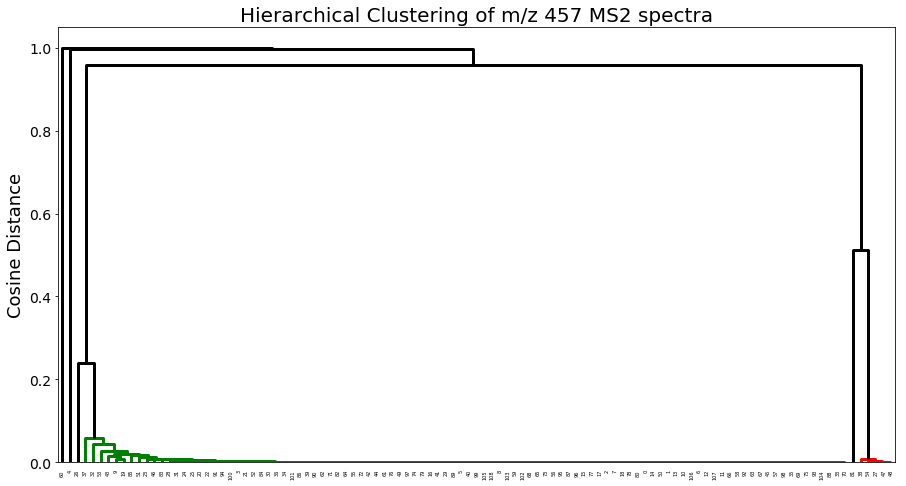

In [16]:
peak_of_interest = 457
cutoff = 0.2

###########################################
peak = pd.pivot_table(data.query('pmz_round == @peak_of_interest'),index=['file','scan'],columns='mz_round',values='inten',aggfunc='max', fill_value=0)
peak.drop(peak.columns[peak.columns >= peak_of_interest],axis=1,inplace=True)

#Clustering linkages followed by dendrogram construction
matplotlib.rcParams['lines.linewidth'] = 3
link = linkage(peak, 'average', metric = 'cosine')
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering of m/z '+str(peak_of_interest)+' MS2 spectra', fontsize=20)
plt.ylabel('Cosine Distance', fontsize=18)
plt.yticks(fontsize=14)
dendrogram(
    link,
    color_threshold=cutoff,
    above_threshold_color='k',
    )
plt.show()


Run the cell below to get details on how many scans are in each cluster generated above. The result will be a list of pairs of numbers (called tuples). The first number in each pair is the cluster number, while the second number indicates how many scans are included in that cluster.


In [17]:
C = fcluster(link, cutoff, criterion="distance")
Counter(C).most_common()

[(1, 100), (3, 5), (5, 1), (2, 1), (6, 1), (4, 1)]

Based on the outputs above, one cluster may have caught your attention. Input the cluster number below and then run the cell in order to generate a consensus fragmentation pattern representing the scans in that cluster.

Text(0.5, 1.0, 'Consensus MS2 spectrum for cluster 1 of m/z 457, based on 100 scans')

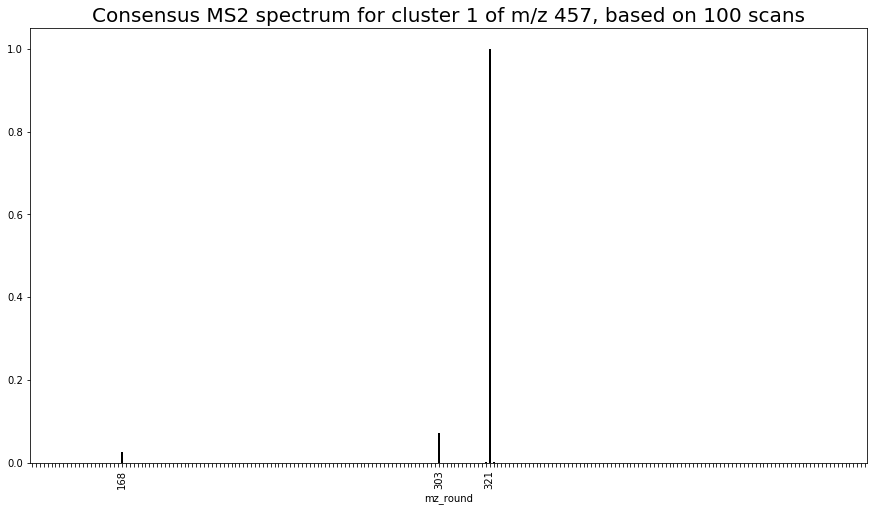

In [18]:
cluster = 1

##################################################################################################################

peak_plot = peak[C == cluster].T/peak[C == cluster].T.max()

xticklab = []
for x in pd.Series(peak_plot.index):
    if x in list(peak_plot.T.median().T[peak_plot.T.median() > .01].index):
        xticklab.append(str(int(x)))
    else:
        xticklab.extend(' ')

plt.figure(figsize=(15,8))
ax = peak_plot.T.median().plot(kind='bar', color='k')
ax.set_xticklabels(xticklab, rotation=90)
ax.set_title('Consensus MS2 spectrum for cluster '+str(cluster)+' of m/z '+str(peak_of_interest)+', based on '+str(len(peak_plot.T))+' scans', fontsize=20)

In the consensus spectrum above, only peaks that are greater than 0.01 in relatvie intensity are labelled. For a full accounting of the peaks in the consensus spectrum, run the below cell.

In [ ]:
peaks = list(peak_plot.T.median().T[peak_plot.T.median() > .00001].index)
peaks

In some cases, it may be useful to calculate the ratios of two fragment peaks across all of the scans in a cluster. This can be done in the cell below.

In [27]:
peak_1 = 321
peak_2 = 323

##################################################################################################################

ratios = peak_plot.T[peak_1]/peak_plot.T[peak_2]
ratios

file                                  scan
./CL001_ms/2015081301_2232cr-1.mzML   620           inf
                                      623           inf
                                      631           inf
                                      635           inf
./CL001_ms/2015081301_2232cr-10.mzML  620           inf
                                                ...    
./CL001_ms/20161110_09_2246G.mzML     665           inf
                                      667           inf
./CL001_ms/20161110_10_2246H.mzML     668     2922492.0
                                      680           inf
                                      686           inf
Length: 100, dtype: float64